In [1]:
import pickle
import os
import pandas as pd
from tqdm import tqdm
from src.models import *
from src.constants import *
from src.plotting import *
from src.pot import *
from src.utils import *
from src.diagnosis import *
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
from time import time
from pprint import pprint
from datetime import datetime, timedelta
from main import  load_dataset, backprop
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 8, 5

def normalize3(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return ((a - min_a) / (max_a - min_a + 0.0001)), min_a, max_a

def convert_to_windows(data, model):
    windows = []
    w_size = model.n_window
    for i, g in enumerate(data):
        if i >= w_size:
            w = data[i - w_size:i]  # cut
        else:
            w = torch.cat([data[0].repeat(w_size - i, 1), data[0:i]])  # pad
        windows.append(w if 'DTAAD' in model.name or 'Attention' in model.name or 'TranAD' in model.name else w.view(-1))
    return torch.stack(windows)

def load_model(modelname, dims):
    import src.models
    model_class = getattr(src.models, modelname)
    model = model_class(dims).double()
    fname = f'checkpoints/{modelname}_{args.dataset}/model.ckpt'
    if os.path.exists(fname) and (not args.retrain or args.test):
        checkpoint = torch.load(fname, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print(f"{color.GREEN}Creating new model: {model.name}{color.ENDC}")
        assert True
    return model

def filter_noise_es(df, alpha=0.4, reduction=False):
    import copy
    new_df = copy.deepcopy(df)
    
    for column in df:
        new_df[column] = df[column].ewm(alpha=alpha, adjust=False).mean()
    
    if reduction:
        return new_df[::len(df)]  # Adjust sparsity if needed
    else:
        return new_df

def wgn_pandas(df_withtime, snr, alpha=0.15, window_size=120):
    df_no_timestamp = df_withtime.drop(columns=['TimeStamp'])
    noisy_df = pd.DataFrame(index=df_no_timestamp.index, columns=df_no_timestamp.columns)

    for start in range(0, len(df_no_timestamp), window_size):
        window = df_no_timestamp.iloc[start:start + window_size]
        
        min_window, max_window = window.min(), window.max()
        #x = (window - min_window) / (max_window - min_window + 1e-4)
        Ps = np.sum(np.power(window, 2), axis=0) / len(window)
        Pn = Ps / (np.power(10, snr / 10))

        noise = np.random.randn(*window.shape) * np.sqrt(Pn.values)
        noisy_window = window + (noise / 100)

        noisy_df.iloc[start:start + window_size] = noisy_window
    
    noisy_df.reset_index(drop=True, inplace=True)
    noisy_df = filter_noise_es(pd.DataFrame(noisy_df, columns=noisy_df.columns), alpha)

    df_timestamp = df_withtime['TimeStamp']
    df_timestamp.reset_index(drop=True, inplace=True)

    df_withtime = pd.concat([df_timestamp, noisy_df], axis=1)
    return df_withtime

def percentage2severity(value):
    return (
        1 if 0 <= value < 5 else
        2 if 5 <= value < 20 else
        3 if 20 <= value < 40 else
        4 if 40 <= value < 75 else
        5 if 75 <= value <= 100 else
        6
    )

feature_set = ['Active Power', 'Reactive Power', 'Governor speed actual', 'UGB X displacement', 'UGB Y displacement',
    'LGB X displacement', 'LGB Y displacement', 'TGB X displacement',
    'TGB Y displacement', 'Stator winding temperature 13',
    'Stator winding temperature 14', 'Stator winding temperature 15',
    'Surface Air Cooler Air Outlet Temperature',
    'Surface Air Cooler Water Inlet Temperature',
    'Surface Air Cooler Water Outlet Temperature',
    'Stator core temperature', 'UGB metal temperature',
    'LGB metal temperature 1', 'LGB metal temperature 2',
    'LGB oil temperature', 'Penstock Flow', 'Turbine flow',
    'UGB cooling water flow', 'LGB cooling water flow',
    'Generator cooling water flow', 'Governor Penstock Pressure',
    'Penstock pressure', 'Opening Wicked Gate', 'UGB Oil Contaminant',
    'Gen Thrust Bearing Oil Contaminant']

dataset_folder = 'data/CustomAWGN30ES15'
df_train = pd.read_csv(os.path.join(dataset_folder, 'train.csv'))
df_test = pd.read_csv(os.path.join(dataset_folder, 'test.csv'))
df_train, df_test = df_train.values[:, 1:], df_test.values[:, 1:]
_, min_a, max_a = normalize3(np.concatenate((df_train, df_test), axis=0))

model_array = ["Attention", "DTAAD", "MAD_GAN", "TranAD", "DAGMM", "USAD"] # , CAE_M "GDN" MSCRED
model_thr = {}
for model_name in model_array:
    model_thr[model_name] = 0

for model_now in model_array:
    with open(f'loss_fold/CustomAWGN30ES15/{model_now}.pickle', 'rb') as handle:
        loss = pickle.load(handle)
    model_thr[model_now] = [np.percentile(loss[:, index], 99) for index in range(len(feature_set))]

measured_horizon = 60 * 2 * 1

df_data_withtime = pd.read_pickle("/run/media/fourier/Data2/Pras/Vale/time-series-autoencoder/my_data_5thn_olah.pickle")
mask = (df_data_withtime['TimeStamp'] >= '2020-01-01 00:00:00')
df_data_withtime = df_data_withtime.loc[mask]

for column_name in df_data_withtime.columns:
    if column_name != 'Load_Type' and column_name != 'TimeStamp':
        df_data_withtime[column_name] = pd.to_numeric(df_data_withtime[column_name], downcast='float')
        
df_anomaly = pd.read_excel("/run/media/fourier/Data2/Pras/Vale/time-series-autoencoder/shutdown_list.xlsx", 'Sheet2')
df_anomaly['Start Time'] = pd.to_datetime(df_anomaly['Start Time'])
df_anomaly['End Time'] = pd.to_datetime(df_anomaly['End Time'])
df_anomaly_unplaned = df_anomaly.copy()

mask = (df_anomaly_unplaned['Interal/External'] == 'Internal') & (df_anomaly_unplaned['Shutdown Type'] == 'Unplanned') & (df_anomaly_unplaned['Start Time'] >= '2020-01-01 00:00:00')
df_anomaly_unplaned = df_anomaly_unplaned.loc[mask]
df_anomaly_unplaned = df_anomaly_unplaned.reset_index(drop=True)
df_anomaly_unplaned = df_anomaly_unplaned.drop(df_anomaly_unplaned.index[[2]])
df_anomaly_unplaned = df_anomaly_unplaned.reset_index(drop=True)
df_anomaly_unplaned

,Start Time,End Time,Event,Activities,Related Component,Action/Cause,Interal/External,Shutdown Details,Startup Details,Supplied Grid after Action,Shutdown Type
0,2023-05-22 20:13:00,2023-05-22 20:32:00,LGS#1 Trip by 86N energized,Mechanical,TGB Oil Level,Repairment,Internal,Trip by 86 N Alarm,Flying Started,FCE Grid,Unplanned
1,2022-03-26 10:07:00,2022-03-26 13:50:00,LGS#1 Trip by 86N energized,Mechanical,Rotor Shaft Current at Lower Generator,Repairment,Internal,Trip by 86N Alarm to Standstill,Start via 4/CS,FCE Grid,Unplanned
2,2021-05-28 06:15:00,2021-05-30 00:58:00,LGS#1 Trip by 86N energized,Mechanical,TGB Cooling Water,Repairment,Internal,Trip by 86N Alarm,Started via 4/CS,FCE Grid,Unplanned


In [ ]:
# index_before = 2
# thr_array_fault = {}

# for failure_index_list in range(3):
#     threshold_percentages = {}
#     end_date_filter = df_anomaly_unplaned.values[failure_index_list, 0] - timedelta(minutes=(100 * index_before) + 5)
#     start_date_filter =  end_date_filter - timedelta(minutes=measured_horizon)

#     mask = (df_data_withtime['TimeStamp'] > start_date_filter.strftime('%Y-%m-%d %H:%M:%S')) & (df_data_withtime['TimeStamp'] <= end_date_filter.strftime('%Y-%m-%d %H:%M:%S'))
#     df_sel = df_data_withtime.loc[mask]
#     df_sel = df_sel.reset_index(drop=True)

#     testD, testO = preprocessPD_loadData(df_sel)
#     threshold_percentages = calcThres_allModel(threshold_percentages, model_array, testD, testO)
    

        
#         # threshold_pass = dict(sorted(threshold_pass.items(), key=lambda item: item[1], reverse=True)[:5])
#         # threshold_percentage_all[idx_model] = threshold_pass

#     # counter_feature = {}
#     # for modex_idx, values_pred in threshold_percentage_all.items():
#     #     for name_feat, percentage in values_pred.items():
#     #         if name_feat in counter_feature:
#     #             counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
#     #             counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
#     #         else:
#     #             counter_feature[name_feat] = {"count": 1, "percentage": percentage}

#     # counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:4])
#     # counter_feature_s2 = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['percentage'] // len(model_array), reverse=True))

#     # for key, value in counter_feature_s2.items():
#     #     counter_feature_s2[key]['count'] = (counter_feature_s2[key]['count'] / len(model_array)) * 100
#     #     counter_feature_s2[key]['severity'] = percentage2severity(counter_feature_s2[key]['percentage'] // len(model_array))
#     #     counter_feature_s2[key]['percentage'] = (counter_feature_s2[key]['percentage'] // len(model_array))

#     # thr_array_fault[df_anomaly_unplaned.values[failure_index_list, 4]] = counter_feature_s2

In [ ]:
index_before = 2

In [121]:
def preprocessPD_loadData(df_sel):
    df_sel = wgn_pandas(df_sel, 30, alpha=0.15)

    df_timestamp = df_sel.iloc[:, 0]
    df_feature =  df_sel.iloc[:, 1:]
    df_feature = df_feature[feature_set]
    raw_active = df_feature['Active Power'].values

    df_feature, _, _ = normalize3(df_feature, min_a, max_a)
    df_feature = df_feature.astype(float)

    test_loader = DataLoader(df_feature.values, batch_size=df_feature.shape[0])
    testD = next(iter(test_loader))
    testO = testD

    return testD, testO, df_timestamp, df_feature

def calcThres_allModel(threshold_percentages, temp_ypreds, model_array, testD, testO):
    threshold_percentages_sorted = threshold_percentages
    for idx_model, model_now in enumerate(model_array):
        model = load_model(model_now, testO.shape[1])
        model.eval()
        torch.zero_grad = True

        if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 
                            'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN', 'TranAD'] or 'DTAAD' in model.name:
            testD_now = convert_to_windows(testD, model)
        else:
            testD_now = testD

        loss, y_pred = backprop(0, model, testD_now, testO, None, None, training=False)
        if 'TranAD' or 'DTAAD' in model.name: testO_now = torch.roll(testO, 1, 0)

        threshold_pass = {}
        for idx_feat in range(loss.shape[-1]):
            thres_bool = loss[:, idx_feat] > model_thr[model_now][idx_feat]
            threshold_pass[feature_set[idx_feat]] = (thres_bool.sum() / thres_bool.shape[0]) * 100
        
        threshold_percentages_sorted[idx_model] = dict(sorted(threshold_pass.items(), key=lambda item: item[1], reverse=True)[:10])
        threshold_percentages[idx_model] = threshold_pass
        temp_ypreds[idx_model] = y_pred

    return threshold_percentages, threshold_percentages_sorted, temp_ypreds

def calc_counterPercentage(threshold_percentages_sorted):
    counter_feature = {}
    for modex_idx, values_pred in threshold_percentages_sorted.items():
        for name_feat, percentage in values_pred.items():
            if name_feat in counter_feature:
                counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
            else:
                counter_feature[name_feat] = {"count": 1, "percentage": percentage}

    counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
    counter_feature_s2 = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['percentage'] // len(model_array), reverse=True))
    #counter_feature_s2_rank = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['count'], reverse=True))

    for key, value in counter_feature_s2.items():
        counter_feature_s2[key]['count'] = (counter_feature_s2[key]['count'] / len(model_array)) * 100
        counter_feature_s2[key]['severity'] = percentage2severity(counter_feature_s2[key]['percentage'] // len(model_array))
        counter_feature_s2[key]['percentage'] = (counter_feature_s2[key]['percentage'] // len(model_array))

    # Find Which Model Have Highest Confidence
    counter_feature_plot = {}
    for index, value in counter_feature_s2.items():
        higher_data = {"model": 0, "percentage": 0}
        for model_idx in threshold_percentage_all:
            if index in threshold_percentage_all[model_idx]:
                if higher_data["percentage"] <= threshold_percentage_all[model_idx][index]:
                    higher_data["model"] = model_idx
                    higher_data["percentage"] = threshold_percentage_all[model_idx][index]
        
        counter_feature_plot[index] = higher_data['model']

    return counter_feature_s2, counter_feature_plot

def calc_counterPercentageTrending(threshold_percentages_sorted):
    counter_feature = {}
    for modex_idx, values_pred in threshold_percentages_sorted.items():
        for name_feat, percentage in values_pred.items():
            if name_feat in counter_feature:
                counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
            else:
                counter_feature[name_feat] = {"count": 1, "percentage": percentage}

    for key, value in counter_feature.items():
        counter_feature[key]['count'] = (counter_feature[key]['count'] / len(model_array)) * 100
        counter_feature[key]['severity'] = percentage2severity(counter_feature[key]['percentage'] // len(model_array))
        counter_feature[key]['percentage'] = (counter_feature[key]['percentage'] // len(model_array))

    return counter_feature

def do_plotSeverityRank():
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(4, 3, figure=fig)

    feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2.keys())]
    for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
        model_idx_highest = counter_feature_plot[feature_set[feature_index_now]]

        ax = fig.add_subplot(gs[idx, :2])
        ax.plot(df_timestamp.values, temp_ypreds[model_idx_highest][:, idx], color='blue', label='Prediction')
        ax.plot(df_timestamp.values, df_feature.values[:, idx], color='red', label='Original')
        ax.set_title(feature_set[feature_index_now])
        ax.legend() 
        ax.grid(True)

    date_format = DateFormatter("%d/%m/%Y - %H:%M")  # Define the desired format
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

    y2 = list(counter_feature_s2.keys())
    x2 = [value['severity'] for value in counter_feature_s2.values()]
    x2_c = [value['count'] for value in counter_feature_s2.values()]

    norm_x2 = [(val - 1) / 5 for val in x2]
    cmap = LinearSegmentedColormap.from_list('severity_colormap', ['green', 'yellow', 'red'])
    colors = [cmap(norm) for norm in norm_x2]

    ax3 = fig.add_subplot(gs[:3, 2])
    bars = ax3.barh(y2, x2, color=colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=6))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', label='Severity')

    for bar, perc in zip(bars, x2_c):
        width = bar.get_width()  # Get the width of the bar
        ax3.text(
            width - 0.1,             # X-coordinate (inside the bar, near the right edge)
            bar.get_y() + bar.get_height() / 2,  # Y-coordinate (center of the bar)
            f"{int(perc)}%",            # Text label (percentage with % sign)
            va='center',           # Vertical alignment
            ha='right',            # Horizontal alignment
            color='black',         # Text color for visibility
            fontsize=9            # Font size
        )
    ax3.invert_yaxis()
    ax3.set_xticks(range(1, 8))
    ax3.set_ylabel("Parameter")
    ax3.set_xlabel("Severity")
    ax3.set_title("Severity Rank")

    fig.suptitle(f"{df_anomaly_unplaned.values[failure_index_list, 4]}_{df_anomaly_unplaned.values[failure_index_list, 0]}", fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    #plt.savefig(f'result_ensemble/{str(df_anomaly_unplaned.values[failure_index_list, 1])}.png')
    #plt.close()
    plt.show()

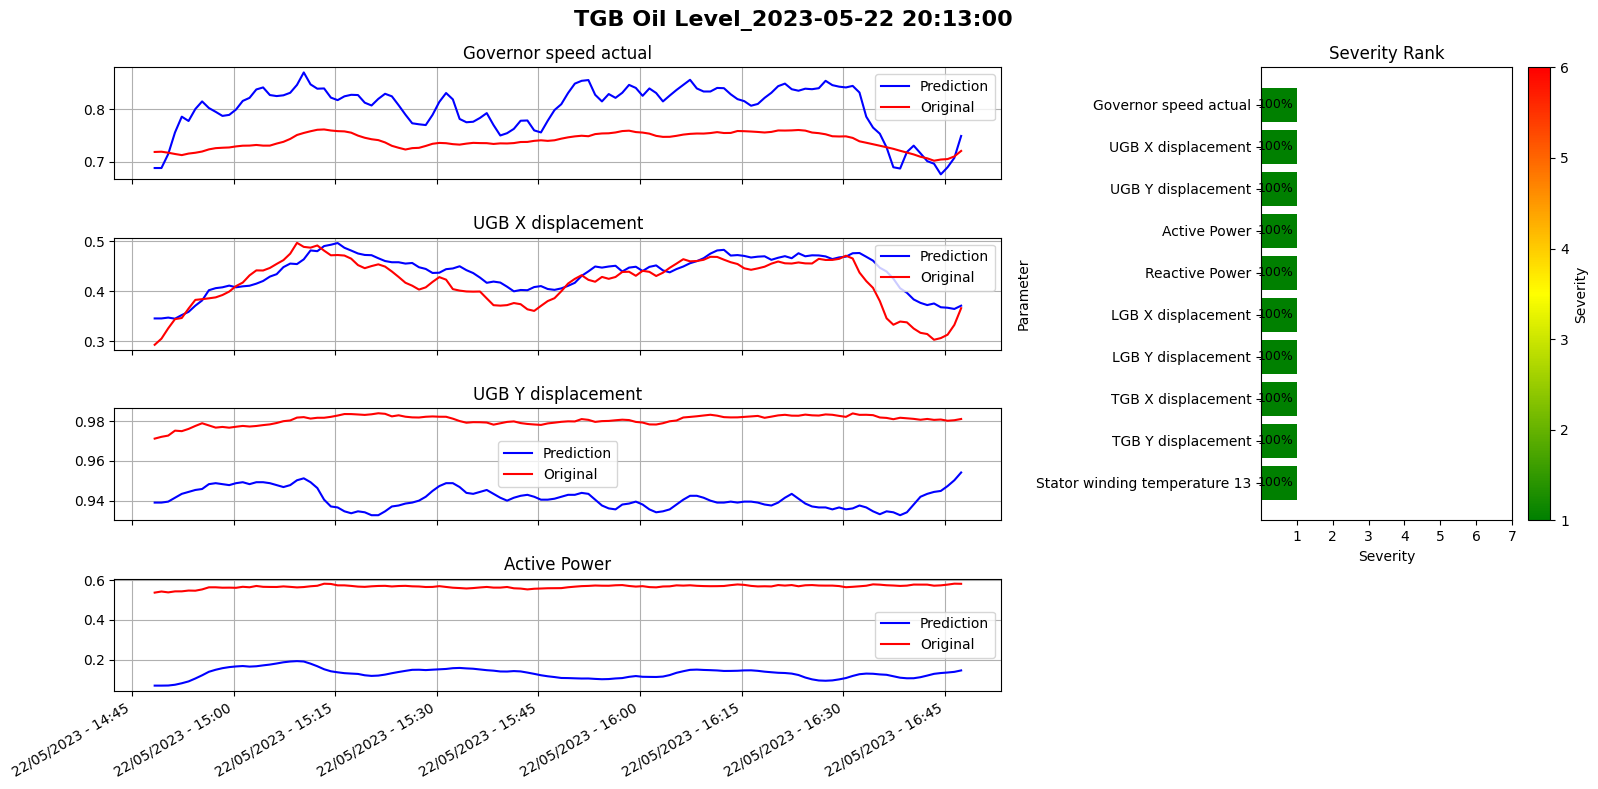

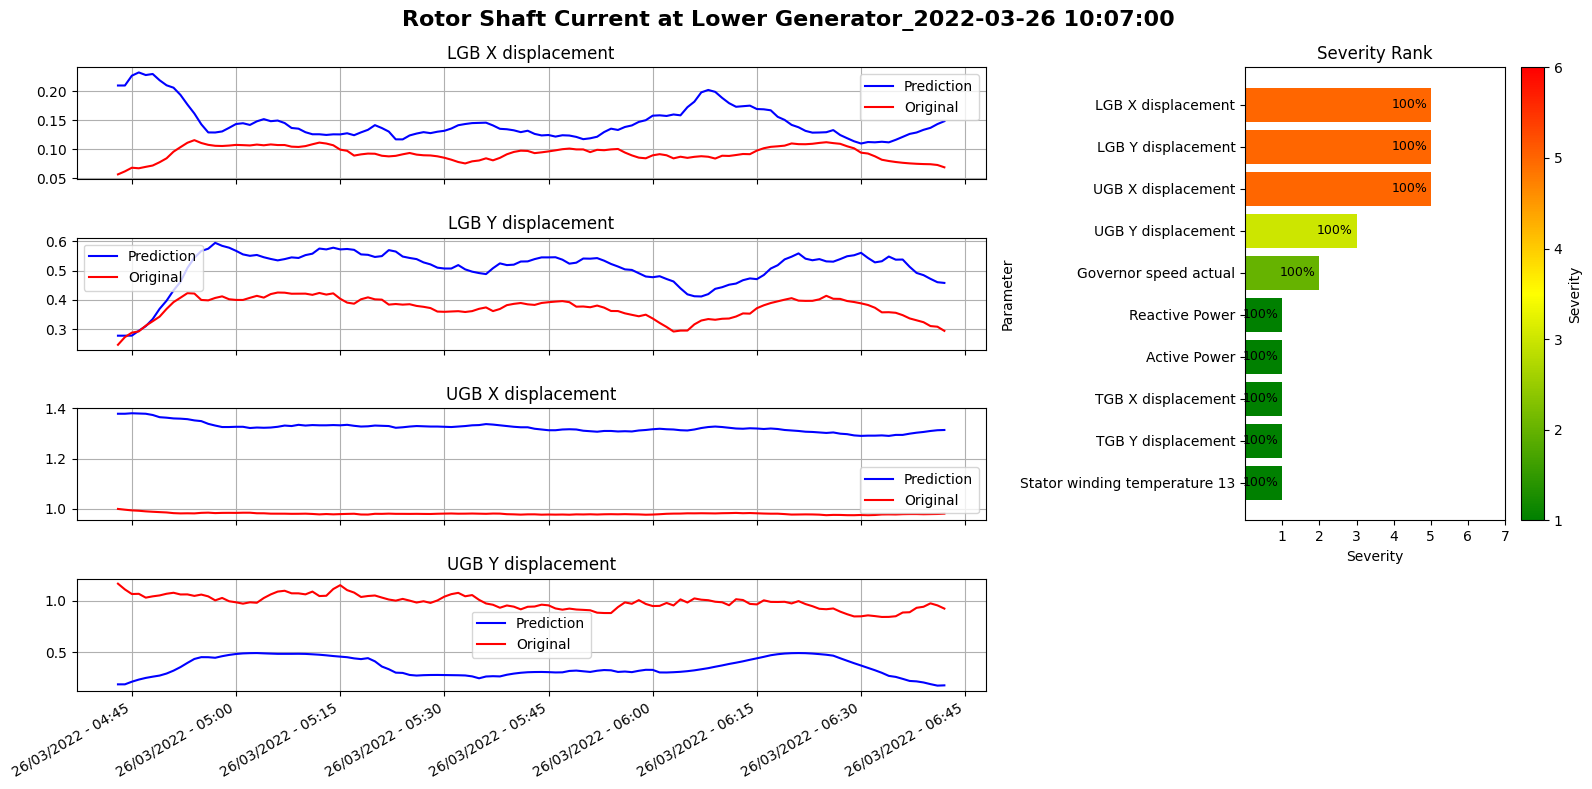

In [122]:
index_before = 2
thr_array_fault = {}

for failure_index_list in range(2):
    threshold_percentages = {}
    temp_ypreds = {}

    end_date_filter = df_anomaly_unplaned.values[failure_index_list, 0] - timedelta(minutes=(100 * index_before) + 5)
    start_date_filter =  end_date_filter - timedelta(minutes=measured_horizon)

    mask = (df_data_withtime['TimeStamp'] > start_date_filter.strftime('%Y-%m-%d %H:%M:%S')) & (df_data_withtime['TimeStamp'] <= end_date_filter.strftime('%Y-%m-%d %H:%M:%S'))
    df_sel = df_data_withtime.loc[mask]
    df_sel = df_sel.reset_index(drop=True)
    
    testD, testO, df_timestamp, df_feature = preprocessPD_loadData(df_sel)
    threshold_percentages, threshold_percentages_sorted, temp_ypreds = calcThres_allModel(threshold_percentages, temp_ypreds, model_array, testD, testO)

    # threshold_percentages to Trending
    counter_feature_s2, counter_feature_plot = calc_counterPercentage(threshold_percentages_sorted)

    do_plotSeverityRank()

In [104]:
for failure_index_list in range(3):
    trend_datas = np.zeros(30)
    datetime_array = []

    interval_gap = 600
    end_date_filter = df_anomaly_unplaned.values[failure_index_list, 0] - timedelta(minutes=5)
    start_trend_filter = df_anomaly_unplaned.values[failure_index_list, 0] - timedelta(days=30)
    current_end_window = start_trend_filter

    total_steps = int((end_date_filter - current_end_window).total_seconds() // (interval_gap * 60)) + 1
    for _ in tqdm(range(total_steps), desc="Progress"):
        start_date_window = current_end_window - timedelta(minutes=measured_horizon)
        mask = (df_data_withtime['TimeStamp'] > start_date_window.strftime('%Y-%m-%d %H:%M:%S')) & (df_data_withtime['TimeStamp'] <= current_end_window.strftime('%Y-%m-%d %H:%M:%S'))
        df_sel = df_data_withtime.loc[mask]
        df_sel = df_sel.reset_index(drop=True)

        threshold_percentages = {}
        temp_ypreds = {}

        testD, testO, df_timestamp, df_feature = preprocessPD_loadData(df_sel)
        threshold_percentages, threshold_percentages_sorted, temp_ypreds = calcThres_allModel(threshold_percentages, temp_ypreds, model_array, testD, testO)

        # threshold_percentages to Trending
        counter_feature_trd = calc_counterPercentageTrending(threshold_percentages)
        trend_data = np.array([counter_feature_trd[key]['percentage'] for key in counter_feature_trd])
        trend_datas = np.vstack([trend_datas, trend_data])
        datetime_array.append(df_timestamp.iloc[-1])

        current_end_window += timedelta(minutes=interval_gap)

    trend_datas = trend_datas[1:, :]
    datetime_array = np.array(datetime_array)

    fig, axes = plt.subplots(30, 1, figsize=(10, 75))
    for i, ax in enumerate(axes):
        ax.plot(datetime_array, trend_datas[:, i])  # Plot data for each row
        ax.set_title(f'{feature_set[i]} || Penyebab: {df_anomaly_unplaned.values[failure_index_list, 4]}_{df_anomaly_unplaned.values[failure_index_list, 0]}', fontsize=10)  # Set title
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_ylim(0, 100)
        ax.set_ylabel("Severity Percentage")

    axes[-1].set_xticks(datetime_array[::7])  # Reduce number of ticks
    #axes[-1].set_xticklabels([ts.strftime('%Y-%m-%d %H:%M') for ts in datetime_array[::7]], rotation=45)

    plt.tight_layout()
    plt.savefig(f'result_trending/{str(df_anomaly_unplaned.values[failure_index_list, 1])}_2.png')
    plt.close()

Progress: 100%|██████████| 72/72 [00:28<00:00,  2.57it/s]


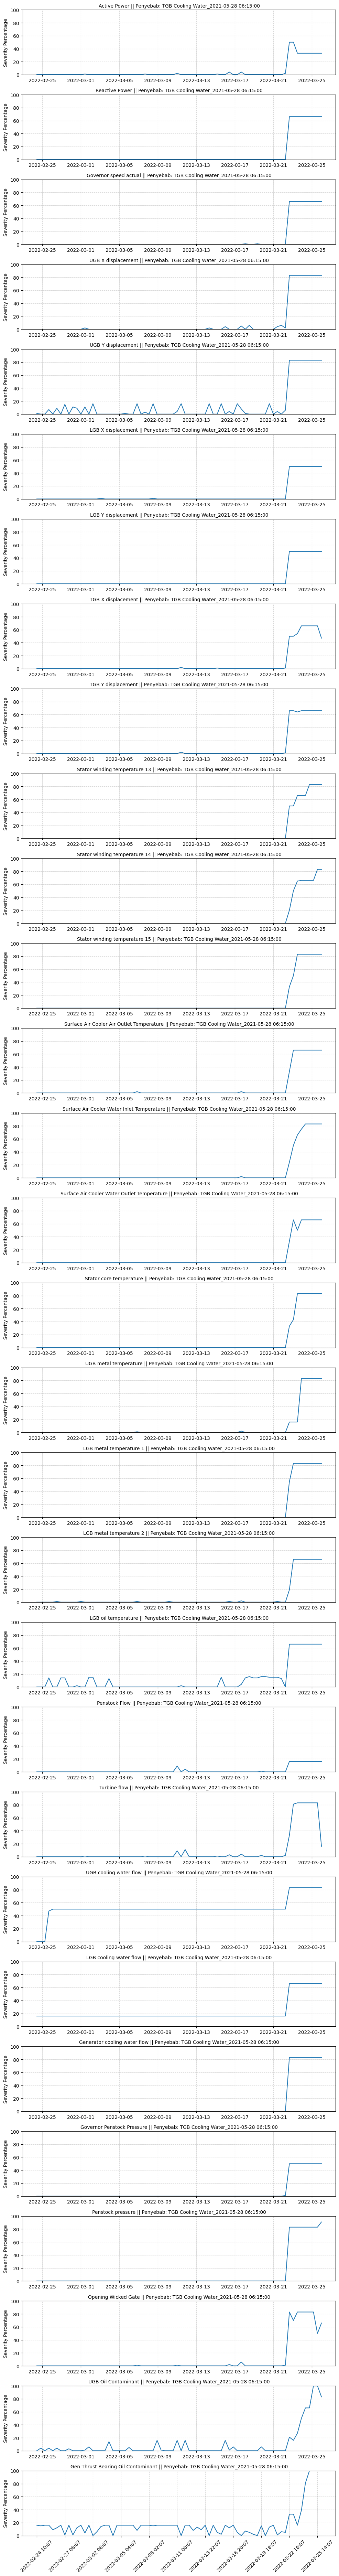

In [78]:
trend_datas[1:, :].shape

(72, 30)

In [85]:
.shape

(72,)

In [77]:
len(datetime_array)

72

Timestamp('2022-03-26 06:42:00')

In [164]:
count_file = 0
while count_file < 15:
    random_index = random.randrange(len(df_data_withtime))
    df_sel = df_data_withtime.iloc[random_index:random_index + (60 * 12 * 1), :]
    df_sel = df_sel.reset_index(drop=True)
    df_timestamp = df_sel.iloc[:, 0]

    firstTimestamp = df_timestamp.iloc[0]
    lastTimestamp = df_timestamp.iloc[-1]
    is_infailure = False
    failure_time = np.inf

    for _, anomaly in df_anomaly.iterrows():
        start = anomaly['Start Time']
        end = anomaly['End Time']
        anomaly_type = anomaly['Interal/External']

        if anomaly_type == 'Internal':
            timedelta_hours = (firstTimestamp - start) / np.timedelta64(1, 'h')
            if timedelta_hours < 0 and np.abs(timedelta_hours) < failure_time:
                failure_time = np.abs(timedelta_hours)

        if (firstTimestamp >= start and firstTimestamp <= end) or (lastTimestamp >= start and lastTimestamp <= end):
            is_infailure = True
            break
    
    if is_infailure != True and failure_time != np.inf:
        count_file = count_file + 1

        df_sel = wgn_pandas(df_sel, 30, alpha=0.15)
        df_timestamp = df_sel.iloc[:, 0]
        df_feature =  df_sel.iloc[:, 1:]
        df_feature = df_feature[feature_set]
        raw_active = df_feature['Active Power'].values

        df_feature, _, _ = normalize3(df_feature, min_a, max_a)
        df_feature = df_feature.astype(float)

        test_loader = DataLoader(df_feature.values, batch_size=df_feature.shape[0])
        testD = next(iter(test_loader))
        testO = testD

        for idx_model, model_now in enumerate(model_array):
            model = load_model(model_now, testO.shape[1])
            model.eval()
            torch.zero_grad = True

            if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 
                                'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN', 'TranAD'] or 'DTAAD' in model.name:
                testD_now = convert_to_windows(testD, model)

            loss, y_pred = backprop(0, model, testD_now, testO, None, None, training=False)
            if 'TranAD' or 'DTAAD' in model.name: testO_now = torch.roll(testO, 1, 0)

            threshold_pass = {}
            for idx_feat in range(loss.shape[-1]):
                thres_bool = loss[:, idx_feat] > model_thr[model_now][idx_feat]
                threshold_pass[feature_set[idx_feat]] = (thres_bool.sum() / thres_bool.shape[0]) * 100
            
            threshold_pass = dict(sorted(threshold_pass.items(), key=lambda item: item[1], reverse=True)[:10])
            threshold_percentage_all[idx_model] = threshold_pass

        counter_feature = {}
        for modex_idx, values_pred in threshold_percentage_all.items():
            for name_feat, percentage in values_pred.items():
                if name_feat in counter_feature:
                    counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                    counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
                else:
                    counter_feature[name_feat] = {"count": 1, "percentage": percentage}

        counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
        counter_feature_s2 = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['percentage'] // len(model_array), reverse=True))
        counter_feature_s2_rank = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['count'], reverse=True))

        for key, value in counter_feature_s2.items():
            counter_feature_s2[key]['count'] = (counter_feature_s2[key]['count'] / len(model_array)) * 100
            counter_feature_s2[key]['severity'] = percentage2severity(counter_feature_s2[key]['percentage'] // len(model_array))
            counter_feature_s2[key]['percentage'] = (counter_feature_s2[key]['percentage'] // len(model_array))

        fig = plt.figure(figsize=(16, 8))
        gs = GridSpec(4, 3, figure=fig)

        feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2.keys())]
        for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
            ax = fig.add_subplot(gs[idx, :2])
            ax.plot(df_timestamp.values, y_pred[:, idx], color='blue', label='Prediction')
            ax.plot(df_timestamp.values, df_feature.values[:, idx], color='red', label='Original')
            ax.set_title(feature_set[feature_index_now])
            ax.legend() 
            ax.grid(True)

        date_format = DateFormatter("%d/%m/%Y - %H:%M")  # Define the desired format
        plt.gca().xaxis.set_major_formatter(date_format)
        plt.gcf().autofmt_xdate()

        y2 = list(counter_feature_s2.keys())
        x2 = [value['severity'] for value in counter_feature_s2.values()]
        x2_c = [value['count'] for value in counter_feature_s2.values()]

        norm_x2 = [(val - 1) / 5 for val in x2]
        cmap = LinearSegmentedColormap.from_list('severity_colormap', ['green', 'yellow', 'red'])
        colors = [cmap(norm) for norm in norm_x2]

        ax3 = fig.add_subplot(gs[:3, 2])
        bars = ax3.barh(y2, x2, color=colors)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=6))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', label='Severity')

        for bar, perc in zip(bars, x2_c):
            width = bar.get_width()  # Get the width of the bar
            ax3.text(
                width - 0.1,             # X-coordinate (inside the bar, near the right edge)
                bar.get_y() + bar.get_height() / 2,  # Y-coordinate (center of the bar)
                f"{int(perc)}%",            # Text label (percentage with % sign)
                va='center',           # Vertical alignment
                ha='right',            # Horizontal alignment
                color='black',         # Text color for visibility
                fontsize=9            # Font size
            )
        ax3.invert_yaxis()
        ax3.set_xticks(range(1, 8))
        ax3.set_ylabel("Parameter")
        ax3.set_xlabel("Severity")
        ax3.set_title("Severity Rank")

        fig.suptitle(f"{firstTimestamp}", fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout()
        plt.savefig(f'result_ensemble/random_{count_file}.png')
        plt.close()

/run/media/fourier/Data2/Pras/Vale/.env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/run/media/fourier/Data2/Pras/Vale/.env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/run/media/fourier/Data2/Pras/Vale/.env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/run/media/fourier/Data2/Pras/Vale/.env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enabl

/run/media/fourier/Data2/Pras/Vale/.env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/run/media/fourier/Data2/Pras/Vale/.env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


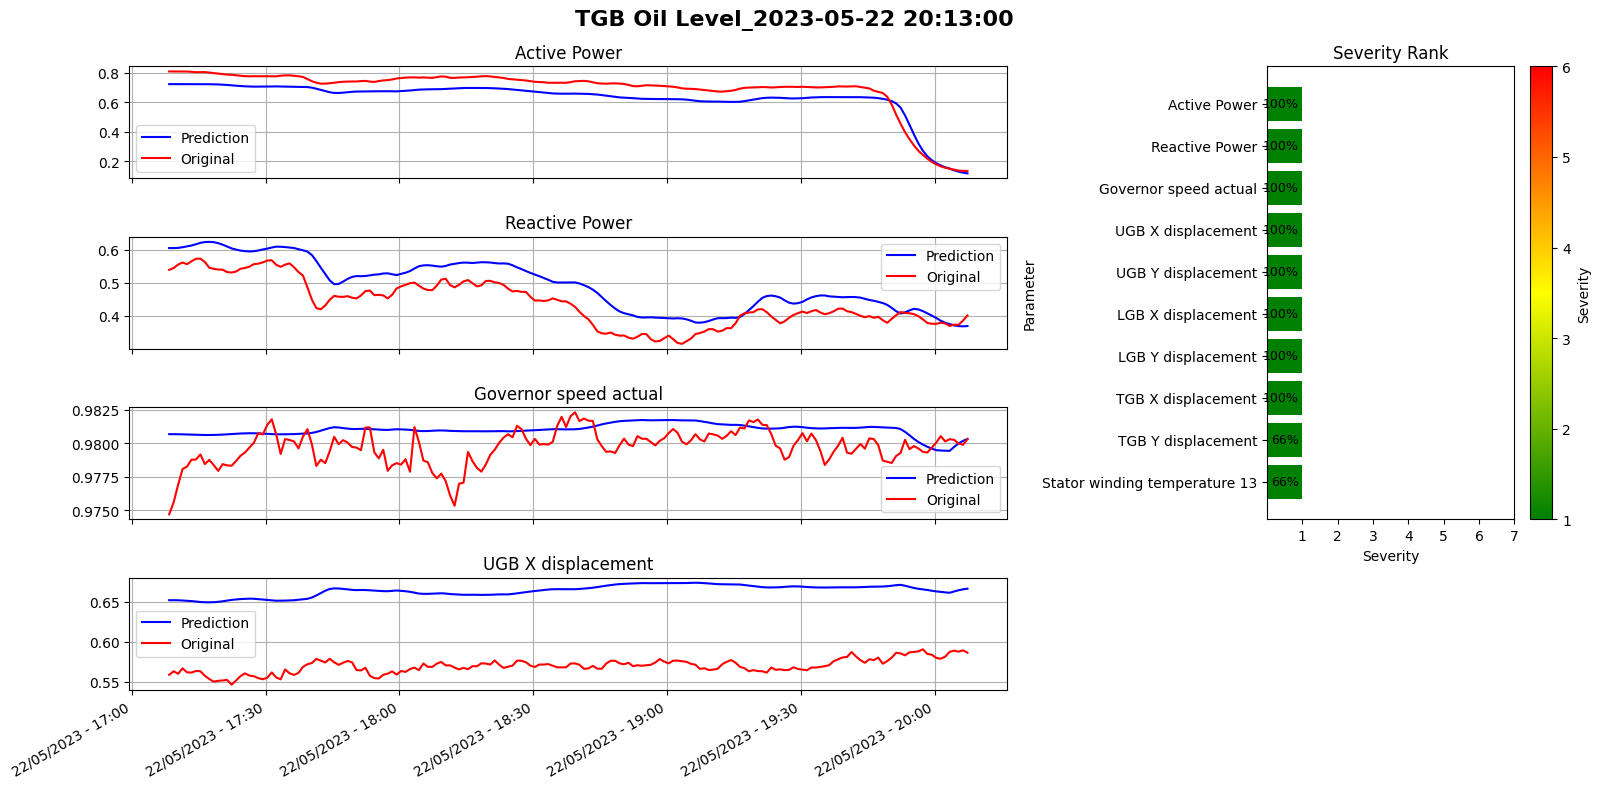

In [173]:
index_before = 0
failure_index_list = 0  

threshold_percentage_all = {}
end_date_filter = df_anomaly_unplaned.values[failure_index_list, 0] - timedelta(minutes=(100 * index_before) + 5)
start_date_filter =  end_date_filter - timedelta(minutes=measured_horizon)

mask = (df_data_withtime['TimeStamp'] > start_date_filter.strftime('%Y-%m-%d %H:%M:%S')) & (df_data_withtime['TimeStamp'] <= end_date_filter.strftime('%Y-%m-%d %H:%M:%S'))
df_sel = df_data_withtime.loc[mask]
df_sel = df_sel.reset_index(drop=True)
df_sel = wgn_pandas(df_sel, 30, alpha=0.15)

df_timestamp = df_sel.iloc[:, 0]
df_feature =  df_sel.iloc[:, 1:]
df_feature = df_feature[feature_set]
raw_active = df_feature['Active Power'].values

df_feature, _, _ = normalize3(df_feature, min_a, max_a)
df_feature = df_feature.astype(float)

test_loader = DataLoader(df_feature.values, batch_size=df_feature.shape[0])
testD = next(iter(test_loader))
testO = testD

for idx_model, model_now in enumerate(model_array):
    model = load_model(model_now, testO.shape[1])
    model.eval()
    torch.zero_grad = True

    if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 
                        'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN', 'TranAD'] or 'DTAAD' in model.name:
        testD_now = convert_to_windows(testD, model)

    loss, y_pred = backprop(0, model, testD_now, testO, None, None, training=False)
    if 'TranAD' or 'DTAAD' in model.name: testO_now = torch.roll(testO, 1, 0)

    threshold_pass = {}
    for idx_feat in range(loss.shape[-1]):
        thres_bool = loss[:, idx_feat] > model_thr[model_now][idx_feat]
        threshold_pass[feature_set[idx_feat]] = (thres_bool.sum() / thres_bool.shape[0]) * 100
    
    threshold_pass = dict(sorted(threshold_pass.items(), key=lambda item: item[1], reverse=True)[:10])
    threshold_percentage_all[idx_model] = threshold_pass

counter_feature = {}
for modex_idx, values_pred in threshold_percentage_all.items():
    for name_feat, percentage in values_pred.items():
        if name_feat in counter_feature:
            counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
            counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
        else:
            counter_feature[name_feat] = {"count": 1, "percentage": percentage}

counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
counter_feature_s2 = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['percentage'] // 6, reverse=True))
counter_feature_s2_rank = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['count'], reverse=True))

for key, value in counter_feature_s2.items():
    counter_feature_s2[key]['count'] = (counter_feature_s2[key]['count'] / 6) * 100
    counter_feature_s2[key]['severity'] = percentage2severity(counter_feature_s2[key]['percentage'] // 6)
    counter_feature_s2[key]['percentage'] = (counter_feature_s2[key]['percentage'] // 6)

fig = plt.figure(figsize=(16, 8))
gs = GridSpec(4, 3, figure=fig)

feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2.keys())]
for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
    ax = fig.add_subplot(gs[idx, :2])
    ax.plot(df_timestamp.values, y_pred[:, idx], color='blue', label='Prediction')
    ax.plot(df_timestamp.values, df_feature.values[:, idx], color='red', label='Original')
    ax.set_title(feature_set[feature_index_now])
    ax.legend() 
    ax.grid(True)

date_format = DateFormatter("%d/%m/%Y - %H:%M")  # Define the desired format
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

y2 = list(counter_feature_s2.keys())
x2 = [value['severity'] for value in counter_feature_s2.values()]
x2_c = [value['count'] for value in counter_feature_s2.values()]

norm_x2 = [(val - 1) / 5 for val in x2]
cmap = LinearSegmentedColormap.from_list('severity_colormap', ['green', 'yellow', 'red'])
colors = [cmap(norm) for norm in norm_x2]

ax3 = fig.add_subplot(gs[:3, 2])
bars = ax3.barh(y2, x2, color=colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=6))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', label='Severity')

for bar, perc in zip(bars, x2_c):
    width = bar.get_width()  # Get the width of the bar
    ax3.text(
        width - 0.1,             # X-coordinate (inside the bar, near the right edge)
        bar.get_y() + bar.get_height() / 2,  # Y-coordinate (center of the bar)
        f"{int(perc)}%",            # Text label (percentage with % sign)
        va='center',           # Vertical alignment
        ha='right',            # Horizontal alignment
        color='black',         # Text color for visibility
        fontsize=9            # Font size
    )
ax3.invert_yaxis()
ax3.set_xticks(range(1, 8))
ax3.set_ylabel("Parameter")
ax3.set_xlabel("Severity")
ax3.set_title("Severity Rank")

fig.suptitle(f"{df_anomaly_unplaned.values[failure_index_list, 4]}_{df_anomaly_unplaned.values[failure_index_list, 0]}", fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

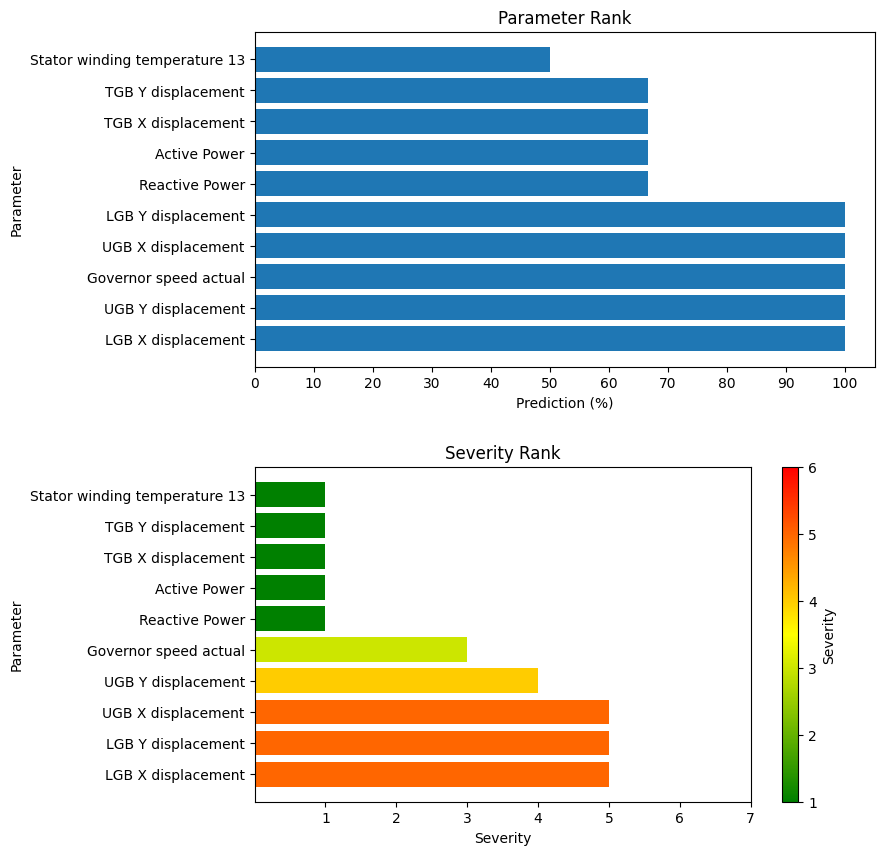

In [110]:
y1 = list(counter_feature_s2_rank.keys())
x1 = [value['count'] for value in counter_feature_s2_rank.values()]

y2 = list(counter_feature_s2.keys())
x2 = [value['severity'] for value in counter_feature_s2.values()]

norm_x2 = [(val - 1) / 5 for val in x2]
cmap = LinearSegmentedColormap.from_list('severity_colormap', ['green', 'yellow', 'red'])
colors = [cmap(norm) for norm in norm_x2]

fig, axs = plt.subplots(2, 1, figsize=(8, 10))
axs[0].barh(y1, x1)
axs[0].set_xticks(range(0, 110, 10))
axs[0].set_ylabel("Parameter")
axs[0].set_xlabel("Prediction (%)")
axs[0].set_title("Parameter Rank")

bars = axs[1].barh(y2, x2, color=colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=6))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs[1], orientation='vertical', label='Severity')
axs[1].set_xticks(range(1, 8))
axs[1].set_ylabel("Parameter")
axs[1].set_xlabel("Severity")
axs[1].set_title("Severity Rank")

plt.subplots_adjust(hspace=0.3)
plt.show()

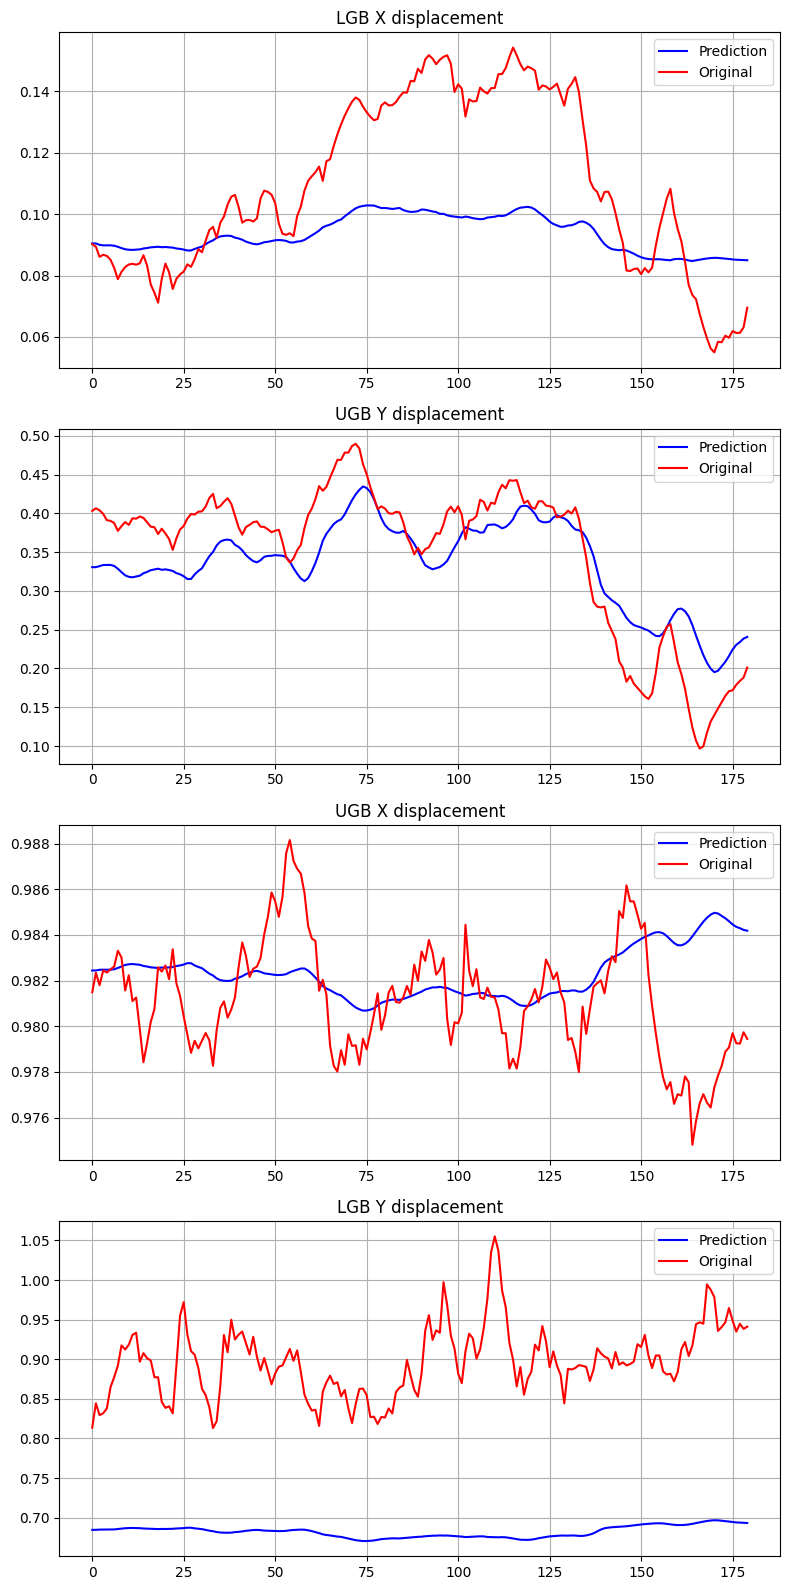

In [56]:
feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2_rank.keys())]

fig, axs = plt.subplots(4, 1, figsize=(8, 16))
for idx, (feature_index_now) in enumerate(feature_index_list):
    axs[idx].plot(y_pred[:, idx], color='blue', label='Prediction')
    axs[idx].plot(df_feature.values[:, idx], color='red', label='Original')
    axs[idx].set_title(feature_set[feature_index_now])
    axs[idx].legend()  # Add legend to each subplot
    axs[idx].grid(True)  # Optional: Add grid for better readability
    # axs[idx].set_ylabel("Features")
    # axs[idx].set_xlabel("Value1")

plt.tight_layout()
plt.show()

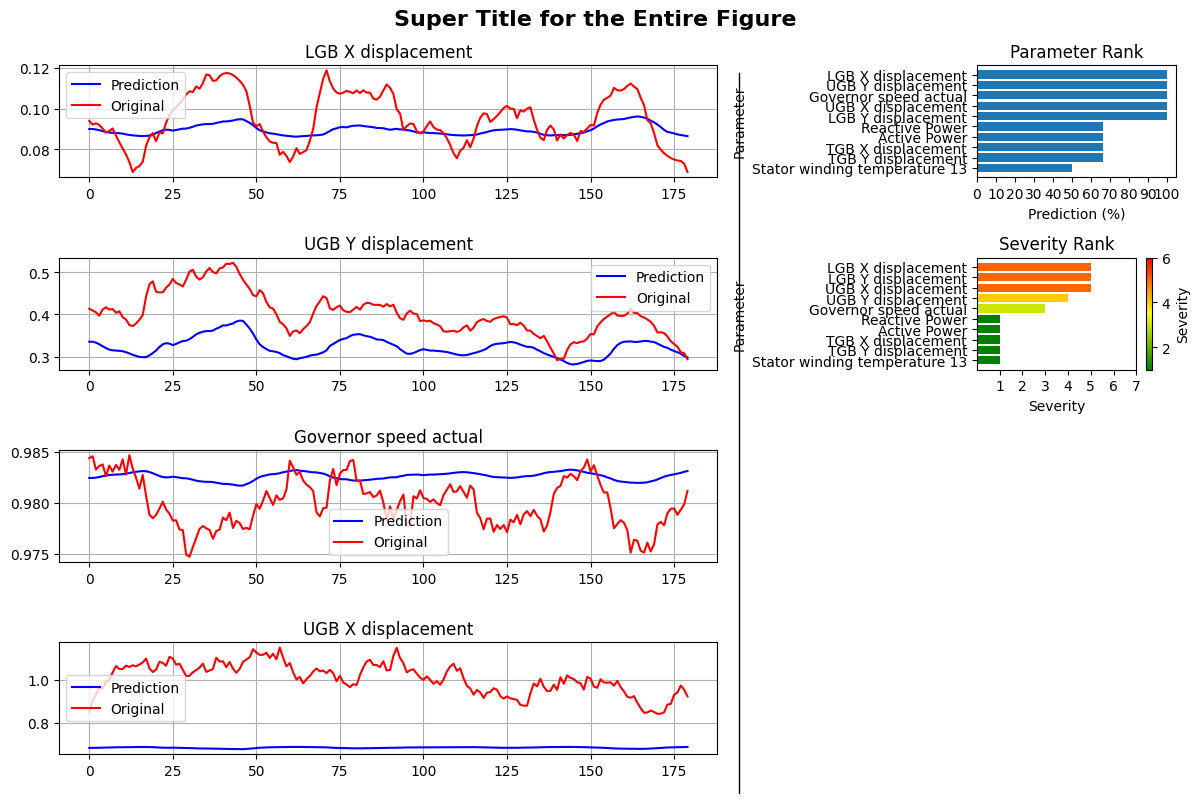

In [113]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(4, 3, figure=fig)

feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2_rank.keys())]
for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
    ax = fig.add_subplot(gs[idx, :2])
    ax.plot(y_pred[:, idx], color='blue', label='Prediction')
    ax.plot(df_feature.values[:, idx], color='red', label='Original')
    ax.set_title(feature_set[feature_index_now])
    ax.legend() 
    ax.grid(True)
    # axs[idx].set_ylabel("Features")
    # axs[idx].set_xlabel("Value1")

y1 = list(counter_feature_s2_rank.keys())
x1 = [value['count'] for value in counter_feature_s2_rank.values()]

y2 = list(counter_feature_s2.keys())
x2 = [value['severity'] for value in counter_feature_s2.values()]

norm_x2 = [(val - 1) / 5 for val in x2]
cmap = LinearSegmentedColormap.from_list('severity_colormap', ['green', 'yellow', 'red'])
colors = [cmap(norm) for norm in norm_x2]

ax2 = fig.add_subplot(gs[0, 2])
ax2.barh(y1, x1)
ax2.invert_yaxis()
ax2.set_xticks(range(0, 110, 10))
ax2.set_ylabel("Parameter")
ax2.set_xlabel("Prediction (%)")
ax2.set_title("Parameter Rank")

ax3 = fig.add_subplot(gs[1, 2])
bars = ax3.barh(y2, x2, color=colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=6))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', label='Severity')
ax3.invert_yaxis()
ax3.set_xticks(range(1, 8))
ax3.set_ylabel("Parameter")
ax3.set_xlabel("Severity")
ax3.set_title("Severity Rank")

fig.add_artist(plt.Line2D(
    [0.62, 0.62],  # X-coordinates (normalized between 0 and 1 for figure space)
    [0, 0.9],        # Y-coordinates (entire figure height)
    transform=fig.transFigure,  # Use figure's coordinate system
    color='black',  # Line color
    linewidth=1,    # Line width
))

fig.suptitle("Super Title for the Entire Figure", fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()